# Calculating Phi slides
Following along [227 slides](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1006343.s001&type=supplementary). (but perhaps implementing differently)

In [1]:
import numpy as np
import pandas as pd

import pyphi.data_models as dm  # Prototype code
import networkx as nx
from networkx.drawing.nx_pydot import pydot_layout
from pyphi.convert import sbs2sbn, sbn2sbs      

import pyphi
import numpy as np
from pprint import pprint

# An example network
#### Slide 18

Self-loops do not plot.  Actual self-edges = [('D', 'D')]


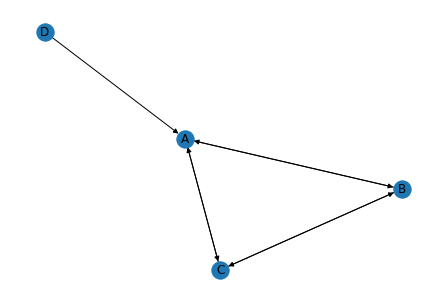

In [2]:
edges = [(0,1),
         (0,2),
         (1,0),
         (1,2),
         (2,0),
         (2,1),
         (3,0),
         (3,3)
        ]
net = dm.Net(edges=edges, SpN=2, func=dm.or_func)
net.draw()
print(f'Self-loops do not plot.  Actual self-edges = {[(i,j) for i,j in net.graph.edges() if i==j]}')

##### Specify operation associated with each node
Default is or_func so ignore those

In [3]:
net.get_node('B').func = dm.and_func
net.get_node('C').func = dm.xor_func
[(n.label, n.func) for n in net.nodes]

[('A', <function pyphi.data_models.or_func(*args)>),
 ('B', <function pyphi.data_models.and_func(*args)>),
 ('C', <function pyphi.data_models.xor_func(*args)>),
 ('D', <function pyphi.data_models.or_func(*args)>)]

#### Calculate OUTstate from INstate using relevent Node funcs
This is _unconditioned_ (system-side). See use of _condition_ keyword to pin the state of some nodes in the INstates.
Each node state is calculated in states.next_state(instate) using node.func

inferered={'bg_cond': {}, 'mech_state': '1000'}


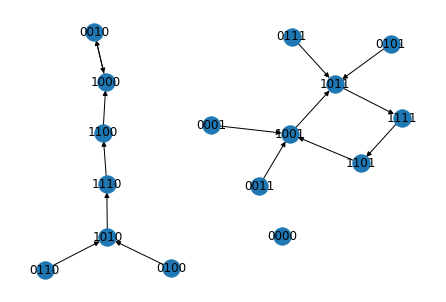

In [4]:
states = dm.States(net=net)
G = states.tpg('1000',draw=True)

In [5]:
list(G.edges())

[('0111', '1011'),
 ('1011', '1111'),
 ('0110', '1010'),
 ('1010', '1110'),
 ('0011', '1001'),
 ('1001', '1011'),
 ('0101', '1011'),
 ('0001', '1001'),
 ('0100', '1010'),
 ('1111', '1101'),
 ('1101', '1001'),
 ('0000', '0000'),
 ('0010', '1000'),
 ('1000', '0010'),
 ('1110', '1100'),
 ('1100', '1000')]

In [6]:
df = states.tpm('1000',backwards=True)  # Unconditioned (full system)
df.style.applymap(dm.hilite_pos)

inferered={'bg_cond': {}, 'mech_state': '1000'}
cand_sys=[0, 1, 2, 3], pur=[0, 1, 2, 3]
source=iABCD, target=oABCD


oABCD,0000,1000,1100,0010,1010,1110,1001,1101,1011,1111
iABCD,,,,,,,,,,
0000,1,0,0,0,0,0,0,0,0,0
1000,0,0,0,1,0,0,0,0,0,0
0100,0,0,0,0,1,0,0,0,0,0
1100,0,1,0,0,0,0,0,0,0,0
0010,0,1,0,0,0,0,0,0,0,0
1010,0,0,0,0,0,1,0,0,0,0
0110,0,0,0,0,1,0,0,0,0,0
1110,0,0,1,0,0,0,0,0,0,0
0001,0,0,0,0,0,0,1,0,0,0


*above matches matrix on slide 23*

### Note on Graph form of TPM
Internally, the Graph form of a TPM is what is used (TPG = TP Graph) since its more flexible and more compact for sparse data.  When we need TPM (for legacy calculation or to compare results, the TPM is formed from the TPG).

In the following figure, disjoint states are clearly visible in graph form.
This suggests possibility of replacing one large matrix with 3 smaller ones.

inferered={'bg_cond': {}, 'mech_state': '1000'}


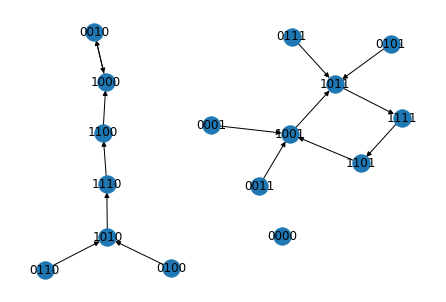

In [7]:
gg = states.tpg('1000',draw=True)
#gg = states.tpg()
#nx.draw(gg)

In [8]:
b,w = zip(*gg.edges)
print(f'instates={b} \noutstates{w}')

instates=('0111', '1011', '0110', '1010', '0011', '1001', '0101', '0001', '0100', '1111', '1101', '0000', '0010', '1000', '1110', '1100') 
outstates('1011', '1111', '1010', '1110', '1001', '1011', '1011', '1001', '1010', '1101', '1001', '0000', '1000', '0010', '1100', '1000')


In [9]:
list(nx.weakly_connected_components(gg))

[{'0001', '0011', '0101', '0111', '1001', '1011', '1101', '1111'},
 {'0010', '0100', '0110', '1000', '1010', '1100', '1110'},
 {'0000'}]

In [10]:
[len(cc) for cc in nx.weakly_connected_components(gg)]

[8, 7, 1]

In [11]:
sum(len(cc)**2 for cc in nx.weakly_connected_components(gg))

114

In [12]:
(4**2)**2

256

#### From above we see we could turn each subgraph into seperate TPMs
114 values instead of 256 without loss info info and still using square TPMs. In graph form, only need 16 values. (just the non-zeros)

# Fix background conditions. Marginalize out background.
_Marginalize out_ means remove from output states, combining columns that differ only in the removed nodes.
#38

#### Condition on D=0 (background condition); #29

In [13]:
# conditioned on D=0 (background condition)
#cand_sys = states.tpm('1000',condition=dict(D=0), backwards=True)
df = states.tpm('1000',candidate_system=list('ABC'), backwards=True)
df.style.applymap(dm.hilite_pos)

inferered={'bg_cond': {'D': '0'}, 'mech_state': '1000'}
cand_sys=[0, 1, 2], pur=[0, 1, 2, 3]
source=iABC, target=oABCD


oABCD,0000,1000,1100,0010,1010,1110
iABC,,,,,,
000,1,0,0,0,0,0
100,0,0,0,1,0,0
010,0,0,0,0,1,0
110,0,1,0,0,0,0
001,0,1,0,0,0,0
101,0,0,0,0,0,1
011,0,0,0,0,1,0
111,0,0,1,0,0,0


*above matches right side of slide 39*

inferered={'bg_cond': {'D': '0'}, 'mech_state': '1000'}


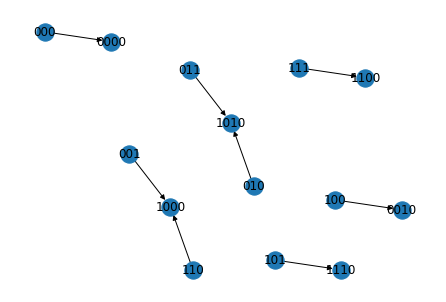

In [14]:
gg = states.tpg('1000',candidate_system=list('ABC'), draw=True)

### Explore aspects not covered in slides
non-deterministic, non-binary nodes, non-square TPM (remove columns 010,011)

# Cause-effect repertoires (42)
This is the power set excluding the null set.

In [15]:
mechanism = list('ABC')
set(net.candidate_mechanisms(mechanism))

{('A',), ('B',), ('B', 'A'), ('C',), ('C', 'A'), ('C', 'B'), ('C', 'B', 'A')}

#58

In [16]:
df.loc[['100']]#.T.style.bar(color='#d65f5f')
 # effect repertoire of Mechanism ABC in state 100; #58

oABCD,0000,1000,1100,0010,1010,1110
iABC,,,,,,
100,0,0,0,1,0,0


#### The following is the Equivalent of #58 but  removes unconnected states
They can always be treated as zero probability.

In [17]:
# list(states.effect_repertoire(state='100', condition=dict(D=0)))

#61

#### #68
Given:
- Current State = 1000
- Mechanism = ABC [default = all-nodes]
- Candidate System = ABC [default = mechanism]
- Purview = BC [default = mechanism]


Inferred:
- Background condition: D=0
- Mechnism State = 100

#here!!!

#### ABC over purview BC (#68)
This is calculated using graph (TPG) which is showm after.  Matrix only shown here to make it easier to compare to slide. Pretty sure this could be made to look almost exactly like slide with sufficient pandas magic.

In [22]:
t2 = states.tpm('1000', mechanism=list('ABC'), candidate_system=list('ABC'), purview=list('BC'), backwards=True)
t2.style.applymap(dm.hilite_pos)

inferered={'bg_cond': {'D': '0'}, 'mech_state': '100'}
cand_sys=[0, 1, 2], pur=[1, 2]
source=iABC, target=oBC


oBC,00,10,01,11
iABC,,,,
000,1,0,0,0
100,0,0,1,0
010,0,0,1,0
110,1,0,0,0
001,1,0,0,0
101,0,0,0,1
011,0,0,1,0
111,0,1,0,0


#### Graph format: only as many edges are there are real transitions

inferered={'bg_cond': {'D': '0'}, 'mech_state': '100'}


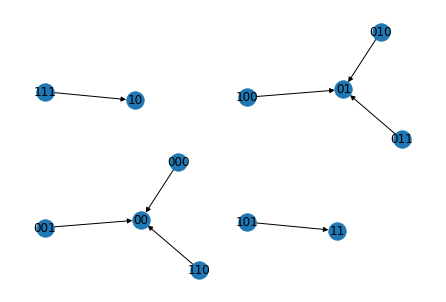

In [21]:
G = states.tpg('1000', list('ABC'), list('ABC'), list('BC'),draw=True)